In [1]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.3 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!nvidia-smi

Sun Oct  3 12:24:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:
!unzip data_splitted.zip

Archive:  data_splitted.zip
   creating: data_splitted/
  inflating: data_splitted/.DS_Store  
  inflating: __MACOSX/data_splitted/._.DS_Store  
   creating: data_splitted/train/
   creating: data_splitted/val/
  inflating: data_splitted/train/.DS_Store  
  inflating: __MACOSX/data_splitted/train/._.DS_Store  
   creating: data_splitted/train/R/
   creating: data_splitted/train/U/
   creating: data_splitted/train/9/
   creating: data_splitted/train/0/
   creating: data_splitted/train/7/
   creating: data_splitted/train/N/
   creating: data_splitted/train/G/
   creating: data_splitted/train/6/
   creating: data_splitted/train/Z/
   creating: data_splitted/train/1/
   creating: data_splitted/train/8/
   creating: data_splitted/train/T/
   creating: data_splitted/train/S/
   creating: data_splitted/train/A/
   creating: data_splitted/train/F/
   creating: data_splitted/train/H/
   creating: data_splitted/train/M/
   creating: data_splitted/train/C/
   creating: data_splitted/train/D/
   c

In [3]:
BATCH_SIZE = 64
EPOCHS = 100
IMG_SIZE = (28, 28)
TRAIN_SIZE = 891
VAL_SIZE = 383
TEST_SIZE = 64

# Data preparation

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import albumentations as A
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import cv2

plt.rcParams["figure.figsize"] = (5,5)

## Load all data

In [30]:
aug = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0, always_apply=0.5),
    #A.Rotate(limit=15, border_mode=cv2.BORDER_REPLICATE, always_apply=False, p=0.5),
    A.ShiftScaleRotate(shift_limit_x=0.15, shift_limit_y=0.05, scale_limit=0.1, rotate_limit=10, border_mode=cv2.BORDER_REPLICATE, always_apply=0.5),
    #A.CoarseDropout(max_holes=6, max_height=5, max_width=5, min_height=5, min_width=5, p=0.75, fill_value=1),
    A.CoarseDropout(max_holes=2, max_height=2, max_width=20, min_height=2, min_width=15, p=0.3, fill_value=1),
])

In [9]:
def transform(image):
    return aug(image=image)['image']

In [10]:
all_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        #width_shift_range=0.15,
        #height_shift_range=0.05,
        #zoom_range=0.2,
        preprocessing_function=transform,
        fill_mode='nearest')
test_datagen = ImageDataGenerator()

In [15]:
all_train_gen = all_datagen.flow_from_directory(
    directory='data_splitted/train/',
    target_size=IMG_SIZE,
    batch_size=TRAIN_SIZE,
    class_mode="categorical",
    color_mode='grayscale',
    seed=42
)
all_val_gen = all_datagen.flow_from_directory(
    directory='data_splitted/val/',
    target_size=IMG_SIZE,
    batch_size=VAL_SIZE,
    class_mode="categorical",
    color_mode='grayscale',
    seed=42
)

# load all data into memory
all_train_data = all_train_gen[0]
all_val_data = all_val_gen[0]

Found 891 images belonging to 31 classes.
Found 383 images belonging to 31 classes.


## OverSampling

In [19]:
!pip install imbalanced-learn

In [20]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
train_data_idx = np.array([i for i in range(len(all_train_data[0]))]).reshape(-1,1)
X_over, y_over = oversample.fit_resample(train_data_idx, all_train_data[1].argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
oversam_data = []
for i in X_over[len(all_train_data[0]):len(X_over)].reshape(-1):
    oversam_data += [all_train_data[0][i]]

oversam_train_data = np.array(list(all_train_data[0]) + oversam_data)
del all_train_data
del oversam_data

In [22]:
all_train_data = (oversam_train_data, tf.keras.utils.to_categorical(y_over, num_classes=31))
del oversam_train_data

## Data loader

In [23]:
train_generator = train_datagen.flow(all_train_data[0], all_train_data[1], batch_size=BATCH_SIZE)
val_generator = test_datagen.flow(all_val_data[0], all_val_data[1], batch_size=BATCH_SIZE)
STEP_SIZE_TRAIN = len(train_generator)
STEP_SIZE_VALID = len(val_generator)

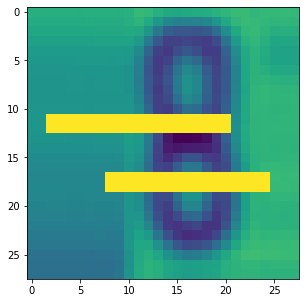

In [40]:
plt.imshow(train_generator[0][0][0].reshape(IMG_SIZE))

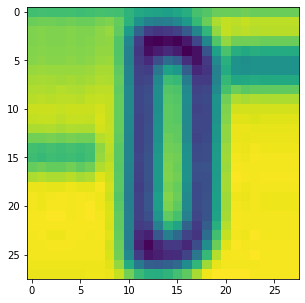

In [41]:
plt.imshow(val_generator[0][0][0].reshape(IMG_SIZE))

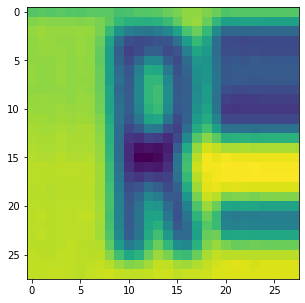

In [42]:
plt.imshow(all_train_data[0][0].reshape(IMG_SIZE))

# Model

Learning rate schedule: 1e-06 to 5e-05


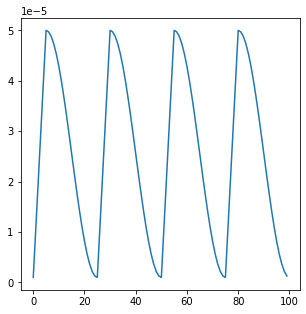

In [5]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0,
                 warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        epoch = epoch % self.max_update
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                    math.pi *
                    (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(25, warmup_steps=5, base_lr=5e-5, final_lr=1e-6, warmup_begin_lr=1e-6)

rng = [i for i in range(EPOCHS)]
y = [scheduler(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g}".format(y[0], max(y)))

In [46]:
class CNN_Model(object):
    def __init__(self, trainable=True):
        self.batch_size = BATCH_SIZE
        self.trainable = trainable
        self.num_epochs = EPOCHS

        # Building model
        self._build_model()

        # Input data
        if trainable:
            self.model.summary()

        self.model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=['accuracy'])

    def _build_model(self):
        # CNN model
        self.model = Sequential()
        self.model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(31, activation='softmax'))

    def train(self):
        # schedule learning rate
        lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=True)
        # Model Checkpoint
        cpt_save = ModelCheckpoint('myCNN_backup_28_BN_new.h5', save_best_only=True, monitor='val_accuracy', mode='max')

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001, mode='max')

        print("Training......")

        self.model.fit(train_generator,
                       steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_generator,
                       validation_steps=STEP_SIZE_VALID,
                       callbacks=[cpt_save, lr_callback, early_stopping], verbose=1,
                       epochs=self.num_epochs)

In [47]:
cnn_model = CNN_Model(trainable=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 128)      

In [77]:
cnn_model.model.load_weights('myCNN_backup_28_BN_new.h5')

In [79]:
# Train with oversampled data
cnn_model.train()

Training......
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
19/19 [==============================] - 1s 57ms/step - loss: 0.0300 - accuracy: 0.9934 - val_loss: 0.0456 - val_accuracy: 0.9922
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 9.964516155915152e-06.
19/19 [==============================] - 1s 52ms/step - loss: 0.0454 - accuracy: 0.9851 - val_loss: 0.0487 - val_accuracy: 0.9922
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 9.858624225078841e-06.
19/19 [==============================] - 1s 52ms/step - loss: 0.0273 - accuracy: 0.9934 - val_loss: 0.0503 - val_accuracy: 0.9922
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 9.683994186497132e-06.
19/19 [==============================] - 1s 52ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 0.0493 - val_accuracy: 0.9922
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 9.443380060197387e-06.
1